In [ ]:
!pip install Catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.5 MB/s eta 0:00:00


In [ ]:
# Data manipulation and linear algebra
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Model and data handling
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error, f1_score
from sklearn.metrics import roc_auc_score, recall_score, precision_score

# Machine Learning Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor, DMatrix
from lightgbm import LGBMRegressor
from prophet import Prophet

# Additional tools
from math import floor, ceil
from tqdm import tqdm
import gc


In [ ]:
# Load the dataset
traffic_data = pd.read_csv('traffic.csv')

# Display the first few rows of the dataframe
traffic_data.head()


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [ ]:
# Display information about the dataframe
traffic_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [ ]:
# Convert 'DateTime' column to datetime type
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

# Extract various components from the 'DateTime' column
traffic_data['Year'] = traffic_data['DateTime'].dt.year
traffic_data['Quarter'] = traffic_data['DateTime'].dt.quarter
traffic_data['Month'] = traffic_data['DateTime'].dt.month
traffic_data['day_of_month'] = traffic_data['DateTime'].dt.day
traffic_data['day_of_week'] = traffic_data['DateTime'].dt.dayofweek
traffic_data['day_of_year'] = traffic_data['DateTime'].dt.dayofyear
traffic_data['Time'] = traffic_data['DateTime'].dt.hour
traffic_data['Date'] = traffic_data['DateTime'].dt.date

# Calculate seconds since the start of the day
traffic_data['Seconds'] = pd.to_timedelta(traffic_data['DateTime'].dt.strftime('%H:%M:%S')).dt.total_seconds().astype(int)


In [ ]:
# Display the first few rows of the dataframe
traffic_data.head()

,DateTime,Junction,Vehicles,ID,Year,Quarter,Month,day_of_month,day_of_week,day_of_year,Time,Date,Seconds
0,2015-11-01 00:00:00,1,15,20151101001,2015,4,11,1,6,305,0,2015-11-01,0
1,2015-11-01 01:00:00,1,13,20151101011,2015,4,11,1,6,305,1,2015-11-01,3600
2,2015-11-01 02:00:00,1,10,20151101021,2015,4,11,1,6,305,2,2015-11-01,7200
3,2015-11-01 03:00:00,1,7,20151101031,2015,4,11,1,6,305,3,2015-11-01,10800
4,2015-11-01 04:00:00,1,9,20151101041,2015,4,11,1,6,305,4,2015-11-01,14400


In [ ]:
# Importing the pickle module
import pickle

# Creating a label encoder and transforming the 'Date' column
date_encoder = LabelEncoder()
traffic_data['Date'] = date_encoder.fit_transform(traffic_data['Date'])

# Saving the encoder to a file
with open('Labelencoder.pkl', 'wb') as file:
    pickle.dump(date_encoder, file)


In [ ]:
# Create a copy of the dataframe
traffic_data_copy = traffic_data.copy()

# Convert 'DateTime' column to datetime type
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

# Convert 'DateTime' column to integer representation (Unix timestamp)
traffic_data['DateTime'] = (traffic_data['DateTime'].view(np.int64) / 10 ** 9).astype(int)


### Cross validation Function

In [ ]:
def time_series_cross_validation(features, target, regressor, num_splits=10, random_seed=42):
    # Prepare for time series cross-validation
    time_split = TimeSeriesSplit(n_splits=num_splits)
    rmse_scores = []    # To store Root Mean Square Error for each fold
    mape_scores = []    # To store Mean Absolute Percentage Error for each fold
    mae_scores = []     # To store Mean Absolute Error for each fold
    fold_predictions = []  # To store model predictions for each fold

    # Loop through the splits of the cross-validator
    for index, (train_idx, test_idx) in enumerate(time_split.split(features)):
        X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
        y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]

        # Fit the model on the training data
        regressor.fit(X_train, y_train)

        # Predict on the test data and calculate errors
        predictions = regressor.predict(X_test)
        rmse = mean_squared_error(y_test, predictions, squared=False)
        mape = mean_absolute_percentage_error(y_test, predictions) * 100
        mae = mean_absolute_error(y_test, predictions)

        # Print the performance of each fold
        print(f'Trained Fold {index}: RMSE: {rmse}, MAPE: {mape}, MAE: {mae}')

        # Append scores and predictions
        rmse_scores.append(rmse)
        mape_scores.append(mape)
        mae_scores.append(mae)

    # Output the average of the scores
    print('Average RMSE is', np.mean(rmse_scores))
    print('Average MAPE is ', np.mean(mape_scores))
    print('Average MAE is', np.mean(mae_scores))

    return fold_predictions


In [ ]:
# Function to apply target encoding with aggregate statistics
def encode_features_with_aggregates(traffic_data):
    # Define the features to be aggregated
    features_to_encode = ['Month', 'Quarter', 'day_of_month', 'day_of_week', 'Time', 'day_of_year']
    # Loop through each feature to create new aggregated columns
    for feature in tqdm(features_to_encode):
        # Compute aggregate statistics for the feature with respect to 'Vehicles'
        aggregated_stats = traffic_data.groupby(feature)['Vehicles'].agg(['std', 'max', 'min', 'mean', 'median']).astype('float32')
        # Rename the columns appropriately
        aggregated_stats.rename(columns=lambda x: f'{feature}_{x}_vehicles', inplace=True)
        # Reset index to flatten the DataFrame
        aggregated_stats.reset_index(inplace=True)
        # Merge the new aggregated data back into the original DataFrame
        traffic_data = traffic_data.merge(aggregated_stats, on=feature, how='left')
        # Free up memory
        gc.collect()
    return traffic_data

# Generate new encoded features for the dataframe
encoded_traffic_data = encode_features_with_aggregates(traffic_data)


100%|██████████| 6/6 [00:01<00:00,  5.70it/s]


In [ ]:
# Print the list of columns in the encoded traffic data dataframe
print(encoded_traffic_data.columns)

Index(['DateTime', 'Junction', 'Vehicles', 'ID', 'Year', 'Quarter', 'Month',
       'day_of_month', 'day_of_week', 'day_of_year', 'Time', 'Date', 'Seconds',
       'Month_std_vehicles', 'Month_max_vehicles', 'Month_min_vehicles',
       'Month_mean_vehicles', 'Month_median_vehicles', 'Quarter_std_vehicles',
       'Quarter_max_vehicles', 'Quarter_min_vehicles', 'Quarter_mean_vehicles',
       'Quarter_median_vehicles', 'day_of_month_std_vehicles',
       'day_of_month_max_vehicles', 'day_of_month_min_vehicles',
       'day_of_month_mean_vehicles', 'day_of_month_median_vehicles',
       'day_of_week_std_vehicles', 'day_of_week_max_vehicles',
       'day_of_week_min_vehicles', 'day_of_week_mean_vehicles',
       'day_of_week_median_vehicles', 'Time_std_vehicles', 'Time_max_vehicles',
       'Time_min_vehicles', 'Time_mean_vehicles', 'Time_median_vehicles',
       'day_of_year_std_vehicles', 'day_of_year_max_vehicles',
       'day_of_year_min_vehicles', 'day_of_year_mean_vehicles',
      

In [ ]:
# Determine the number of rows in the encoded traffic data dataframe
print(len(encoded_traffic_data))

48120


In [ ]:
# Filter and create separate dataframes for each junction
traffic_data_junction1 = encoded_traffic_data.loc[encoded_traffic_data['Junction'] == 1]
traffic_data_junction2 = encoded_traffic_data.loc[encoded_traffic_data['Junction'] == 2]
traffic_data_junction3 = encoded_traffic_data.loc[encoded_traffic_data['Junction'] == 3]
traffic_data_junction4 = encoded_traffic_data.loc[encoded_traffic_data['Junction'] == 4]

# Reset the index for each dataframe without keeping the old index
traffic_data_junction1.reset_index(inplace=True, drop=True)
traffic_data_junction2.reset_index(inplace=True, drop=True)
traffic_data_junction3.reset_index(inplace=True, drop=True)
traffic_data_junction4.reset_index(inplace=True, drop=True)


###   Modelling of Junction - 1

In [ ]:
# Declaring Input and Output Variables for junction 1 traffic data
X_junction1 = traffic_data_junction1.drop(['Vehicles', 'ID', 'Seconds', 'Junction'], axis=1)
y_junction1 = traffic_data_junction1['Vehicles']


In [ ]:
# Calculate the split index for training and validation sets
train_size = ceil(0.8 * len(traffic_data_junction1))
X_train_junction1 = X_junction1.iloc[:train_size]
y_train_junction1 = y_junction1.iloc[:train_size]
X_valid_junction1 = X_junction1.iloc[train_size:]
y_valid_junction1 = y_junction1.iloc[train_size:]

# Display the first few rows of the validation input data
X_valid_junction1.head()



,DateTime,Year,Quarter,Month,day_of_month,day_of_week,day_of_year,Time,Date,Month_std_vehicles,...,Time_std_vehicles,Time_max_vehicles,Time_min_vehicles,Time_mean_vehicles,Time_median_vehicles,day_of_year_std_vehicles,day_of_year_max_vehicles,day_of_year_min_vehicles,day_of_year_mean_vehicles,day_of_year_median_vehicles
11674,1488362400,2017,1,3,1,2,60,10,486,20.499683,...,20.842903,107.0,1.0,24.229925,15.0,22.523212,98.0,2.0,27.351191,21.0
11675,1488366000,2017,1,3,1,2,60,11,486,20.499683,...,24.142347,136.0,1.0,27.495262,17.0,22.523212,98.0,2.0,27.351191,21.0
11676,1488369600,2017,1,3,1,2,60,12,486,20.499683,...,24.568724,129.0,2.0,28.403990,18.0,22.523212,98.0,2.0,27.351191,21.0
11677,1488373200,2017,1,3,1,2,60,13,486,20.499683,...,21.684610,118.0,2.0,25.588530,17.0,22.523212,98.0,2.0,27.351191,21.0
11678,1488376800,2017,1,3,1,2,60,14,486,20.499683,...,23.902777,162.0,1.0,27.702744,19.0,22.523212,98.0,2.0,27.351191,21.0


In [ ]:
!pip install lightgbm

In [ ]:
def evaluate_model(model, X_train, y_train, X_valid, y_valid, model_name):
    """ Train and evaluate the model, then print the RMSE and MAPE scores. """
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, predictions, squared=False)
    mape = mean_absolute_percentage_error(y_valid, predictions) * 100
    print(f"{model_name} RMSE score on validation data is: {rmse}")
    print(f"{model_name} MAPE score on validation data is: {mape}%")
    print('--------' * 20)

# Models to evaluate
models = [
    (LinearRegression(), "LinearRegression"),
    (Lasso(), "LassoRegression"),
    (Ridge(), "RidgeRegression"),
    (CatBoostRegressor(verbose=False, iterations=100), "CatBoost"),
    (LGBMRegressor(), "LGBM"),
    (XGBRegressor(), "XGBoost"),
    (AdaBoostRegressor(), "AdaBoost"),
    (GradientBoostingRegressor(), "Gradient Boosting"),
    (DecisionTreeRegressor(), "DecisionTree"),
    (RandomForestRegressor(), "RandomForest"),
    (SVR(), "SVC"),
    (LinearSVR(), "LinearSVC")
]

# Evaluate each model
for model, name in models:
    evaluate_model(model, X_train_junction1, y_train_junction1, X_valid_junction1, y_valid_junction1, name)


LinearRegression RMSE score on validation data is: 12.854839687861723
LinearRegression MAPE score on validation data is: 15.230172435752745%
----------------------------------------------------------------------------------------------------------------------------------------------------------------
LassoRegression RMSE score on validation data is: 12.790992639468318
LassoRegression MAPE score on validation data is: 17.67307387925548%
----------------------------------------------------------------------------------------------------------------------------------------------------------------
RidgeRegression RMSE score on validation data is: 12.695813291494545
RidgeRegression MAPE score on validation data is: 15.475676546083061%
----------------------------------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.61275e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


CatBoost RMSE score on validation data is: 17.97672344841789
CatBoost MAPE score on validation data is: 18.75726980066406%
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1783
[LightGBM] [Info] Number of data points in the train set: 11674, number of used features: 37
[LightGBM] [Info] Start training from score 39.523128
LGBM RMSE score on validation data is: 7.026064213871266
LGBM MAPE score on validation data is: 7.906486965945958%
----------------------------------------------------------------------------------------------------------------------------------------------------------------
XGBoost RMSE score on validation 

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


###prophet modelling

In [ ]:
# Calculate the index to split the training and test sets for Junction 1 data
split_index = ceil(0.8 * len(traffic_data_junction1))

# Splitting the data into training and test datasets
train_junction1 = traffic_data_junction1.iloc[:split_index]
test_junction1 = traffic_data_junction1.iloc[split_index:]

# Retrieve and set the 'DateTime' column for train and test sets from the original dataframe
train_junction1['DateTime'] = list(traffic_data_copy.loc[traffic_data_copy['Junction'] == 1]['DateTime'].iloc[:split_index])
test_junction1['DateTime'] = list(traffic_data_copy.loc[traffic_data_copy['Junction'] == 1]['DateTime'].iloc[split_index:])

# Convert 'DateTime' columns to datetime type
train_junction1['DateTime'] = pd.to_datetime(train_junction1['DateTime'])
test_junction1['DateTime'] = pd.to_datetime(test_junction1['DateTime'])

# Drop unnecessary columns from train and test sets
train_junction1.drop(['Seconds', 'Junction', 'ID',], axis=1, inplace=True)
test_junction1.drop(['Seconds','Junction', 'ID',], axis=1, inplace=True)

# Rename columns to be suitable for modeling
train_junction1 = train_junction1.rename(columns={"DateTime": "ds", "Vehicles": "y"})
test_junction1 = test_junction1.rename(columns={"DateTime": "ds", "Vehicles": "y"})

# Reset index for both datasets
train_junction1.reset_index(drop=True, inplace=True)
test_junction1.reset_index(drop=True, inplace=True)


<ipython-input-24-54cdc3d30be3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_junction1['DateTime'] = list(traffic_data_copy.loc[traffic_data_copy['Junction'] == 1]['DateTime'].iloc[:split_index])
<ipython-input-24-54cdc3d30be3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_junction1['DateTime'] = list(traffic_data_copy.loc[traffic_data_copy['Junction'] == 1]['DateTime'].iloc[split_index:])
<ipython-input-24-54cdc3d30be3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [ ]:
train_junction1.head()

,Date,Vehicle_Count,Year,Quarter,Month,day_of_month,day_of_week,day_of_year,Time,Date,...,Time_std_vehicles,Time_max_vehicles,Time_min_vehicles,Time_mean_vehicles,Time_median_vehicles,day_of_year_std_vehicles,day_of_year_max_vehicles,day_of_year_min_vehicles,day_of_year_mean_vehicles,day_of_year_median_vehicles
0,2015-11-01 00:00:00,15,2015,4,11,1,6,305,0,0,...,19.148046,109.0,1.0,23.540648,16.0,17.197771,77.0,1.0,16.701389,11.0
1,2015-11-01 01:00:00,13,2015,4,11,1,6,305,1,0,...,16.310963,81.0,1.0,19.654863,13.0,17.197771,77.0,1.0,16.701389,11.0
2,2015-11-01 02:00:00,10,2015,4,11,1,6,305,2,0,...,14.159041,69.0,1.0,17.102743,11.0,17.197771,77.0,1.0,16.701389,11.0
3,2015-11-01 03:00:00,7,2015,4,11,1,6,305,3,0,...,12.333346,57.0,1.0,14.847382,10.0,17.197771,77.0,1.0,16.701389,11.0
4,2015-11-01 04:00:00,9,2015,4,11,1,6,305,4,0,...,10.668347,48.0,1.0,12.973067,9.0,17.197771,77.0,1.0,16.701389,11.0


In [ ]:

# Initialize the Prophet model with yearly seasonality
model = Prophet(yearly_seasonality=True)

# Add regressors to the model for all columns except 'ds' and 'y'
for col in train_junction1.columns:
    if col not in ['ds', 'y']:
        model.add_regressor(col)

# Fit the model to the training data
model.fit(train_junction1)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpzy0rgbdc/fv50tkhi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzy0rgbdc/_56d8glo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29627', 'data', 'file=/tmp/tmpzy0rgbdc/fv50tkhi.json', 'init=/tmp/tmpzy0rgbdc/_56d8glo.json', 'output', 'file=/tmp/tmpzy0rgbdc/prophet_modelr_yv4wka/prophet_model-20240517164150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:41:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:42:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Rename columns for Prophet compatibility in the test dataset
# test_for_prophet = test_junction1.rename(columns={"Date": "ds", "Vehicle_Count": "y"}).drop('y', axis=1)

# Making predictions using the trained Prophet model
forecast = model.predict(test_junction1)

# Extracting predicted values
predicted_values = forecast['yhat']

# Displaying selected columns from the forecast dataframe
forecast_display = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']]
forecast_display.head()


,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2017-03-01 10:00:00,72.873144,64.864251,81.239235,92.350045,92.350045,92.350045
1,2017-03-01 11:00:00,78.922909,71.335590,87.219809,92.355676,92.355676,92.355676
2,2017-03-01 12:00:00,79.975078,71.747425,88.851886,92.361307,92.361307,92.361307
3,2017-03-01 13:00:00,74.123643,65.534688,82.191463,92.366938,92.366938,92.366938
4,2017-03-01 14:00:00,77.622274,69.623566,86.029895,92.372569,92.372569,92.372569


In [ ]:
# Extract the actual 'Vehicle_Count' values from the test data set (which was renamed to 'y')
y_test = test_junction1['y']

# Calculate the MAPE using the actual and predicted values
prof_MAPE = mean_absolute_percentage_error(y_test, predicted_values) * 100

# Print the MAPE score formatted to two decimal places
print("Prophet Model MAPE score on validation set is : {:.2f}%".format(prof_MAPE))


Prophet Model MAPE score on validation set is : 14.21%


In [ ]:
prof_RMSE= mean_squared_error(y_test,predicted_values, squared=False)
print("Prophet Model RMSE score on validation set is : {:.2f} ".format(prof_RMSE))

Prophet Model RMSE score on validation set is : 13.60 


### Arimax Model for JUNCTION-1

In [ ]:
# Drop unnecessary columns from the junction 1 data
traffic_data_junction1 = traffic_data_junction1.drop(['Seconds',  'Junction', 'ID',], axis=1)

# Retrieve the 'DateTime' values for junction 1 from the original dataframe and update them in the junction 1 traffic data
traffic_data_junction1['DateTime'] = list(traffic_data_copy.loc[traffic_data_copy['Junction'] == 1]['DateTime'])


In [ ]:
# Split the traffic data for junction 1 into training and test datasets based on the previously calculated index 'a'
train_junction1 = traffic_data_junction1.iloc[:split_index]
test_junction1 = traffic_data_junction1.iloc[split_index:]

# Set 'DateTime' as the index for both training and test datasets
train_junction1.set_index('DateTime', inplace=True)
test_junction1.set_index('DateTime', inplace=True)


In [ ]:
# Initialize list to hold column names excluding 'Vehicles'
column_list = []

# Populate the list with names of all columns in the training data except for 'Vehicles'
for column in train_junction1.columns:
    if column != 'Vehicles':
        column_list.append(column)


In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.2 MB/s eta 0:00:00


In [ ]:
# Importing necessary libraries for ARIMA modeling
from pmdarima import auto_arima
import warnings

# Setting to ignore unnecessary warnings to keep output clean
warnings.filterwarnings("ignore")

# Running stepwise auto ARIMA to find the best ARIMA model parameters
# Including exogenous variables (if any)
model_fit = auto_arima(train_junction1['Vehicles'], exogenous=train_junction1[column_list],
                       trace=True, suppress_warnings=True)

# Display the summary of the fitted model
model_fit.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=41.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=73801.230, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=73405.562, Time=0.85 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=73476.352, Time=3.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=73799.235, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=73281.894, Time=1.48 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=73239.872, Time=3.36 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=73225.318, Time=3.94 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=73116.258, Time=6.65 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=71801.080, Time=30.88 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=73216.744, Time=12.97 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=71776.836, Time=62.52 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=53.10 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=69.78 sec
 ARIMA(4,1,3)(0,0,0)[0] interce

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11674
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -35879.485
Date:                Fri, 17 May 2024   AIC                          71774.970
Time:                        16:53:40   BIC                          71833.890
Sample:                    11-01-2015   HQIC                         71794.762
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1889      0.042     28.479      0.000       1.107       1.271
ar.L2         -0.2288      0.045     -5.133      0.000      -0.316      -0.141
ar.L3       6.647e-05      0.012      0.006      0.996      -0.023       0.024
ar.L4          0.0182      0.013      1.414      0.157      -0.007       0.044
ar.L5         -0.1555      0.011    -13.960      0.000      -0.177      -0.134
ma.L1         -1.1441      0.042    -27.109      0.000      -1.227      -1.061
ma.L2          0.1879      0.041      4.608      0.000       0.108       0.268
sigma2        27.3696      0.185    147.849      0.000      27.007      27.732
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             24263.46
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Importing ARIMA model class from statsmodels library
from statsmodels.tsa.arima.model import ARIMA

# Initialize and fit the ARIMA model with external regressors and specified order
arima_model = ARIMA(train_junction1['Vehicles'], exog=train_junction1[column_list], order=(5,1,2))
fitted_model = arima_model.fit()

# Display the summary of the fitted ARIMA model
fitted_model.summary()


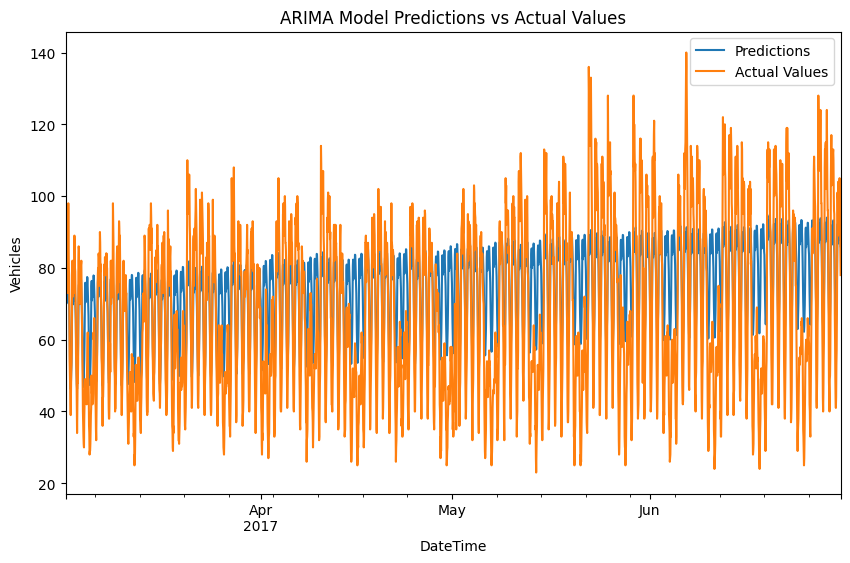

In [ ]:
# Define the range for predictions
start = len(train_junction1)
end = len(train_junction1) + len(test_junction1) - 1

# Predict using the fitted ARIMA model with exogenous variables
predictions = fitted_model.predict(exog=test_junction1[column_list], start=start, end=end, typ='levels').rename('ARIMA predictions')

# Prepare a DataFrame to hold the predictions and their corresponding dates
preds = pd.DataFrame({
    'DateTime': test_junction1.index,
    'Predictions': predictions
})

# Set the 'DateTime' column as the index
preds.set_index('DateTime', inplace=True)

# Plot the predictions against the actual values
preds['Predictions'].plot(legend=True, figsize=(10, 6))
test_junction1['Vehicles'].plot(legend=True)

plt.title('ARIMA Model Predictions vs Actual Values')
plt.xlabel('DateTime')
plt.ylabel('Vehicles')
plt.legend(['Predictions', 'Actual Values'])
plt.show()


In [ ]:
# Calculate RMSE and MAPE for the ARIMAX model predictions
ARIMA_RMSE = mean_squared_error(test_junction1['Vehicles'], predictions, squared=False)
ARIMA_MAPE = mean_absolute_percentage_error(test_junction1['Vehicles'], predictions) * 100

# Print the RMSE and MAPE scores
print("RMSE of ARIMAX: {:.2f}".format(ARIMA_RMSE))
print("MAPE of ARIMAX: {:.2f}%".format(ARIMA_MAPE))


RMSE of ARIMAX: 18.08
MAPE of ARIMAX: 28.66%


In [ ]:
# # Create a DataFrame to store performance metrics for various models
# model_performance = pd.DataFrame({
#     "Model": [
#         "Linear Regression", "Lasso", "Ridge", "CatBoost", "Random Forest",
#         "Decision Tree", "SVR", "Linear SVR", "AdaBoost",
#         "Gradient Boosting", "LGBM", "XGBoost", "Prophet", "ARIMAX"
#     ],
#     "RMSE": [
#         lg_RMSE, l_RMSE, rr_RMSE, cat_RMSE, rf_RMSE,
#         dt_RMSE, svc_RMSE, lsvc_RMSE, ab_RMSE,
#         nb_RMSE, lgb_RMSE, xg_RMSE, prof_RMSE, ARIMA_RMSE
#     ],
#     "MAPE": [
#         lg_MAPE, l_MAPE, rr_MAPE, cat_MAPE, rf_MAPE,
#         dt_MAPE, svc_MAPE, lsvc_MAPE, ab_MAPE,
#         nb_MAPE, lgb_MAPE, xg_MAPE, prof_MAPE, ARIMA_MAPE
#     ]
# })

# # Calculate the average score as the mean of RMSE and MAPE
# model_performance['Average Score'] = (model_performance['RMSE'] + model_performance['MAPE']) / 2

# # Sort the DataFrame by the average score
# model_performance = model_performance.sort_values(by=['Average Score'])

# # Display the sorted DataFrame
# display(model_performance)


### Choosing Best Model(LGBM) as  Final model and Hyper Tuning

In [ ]:
# Splitting the data into training and validation sets based on index 'a'
train_features = X_junction1.iloc[:split_index]
train_target = y_junction1.iloc[:split_index]
validation_features = X_junction1.iloc[split_index:]
validation_target = y_junction1.iloc[split_index:]

# Instantiate and configure the LightGBM model
lightgbm_model = LGBMRegressor(num_iterations=510, learning_rate=0.07007)

# Fit the LightGBM model to the training data
lightgbm_model.fit(train_features, train_target)

# Generate predictions on the validation set
predictions = lightgbm_model.predict(validation_features)

# Evaluate the model's performance using various metrics
rmse_score = mean_squared_error(validation_target, predictions, squared=False)
mape_score = mean_absolute_percentage_error(validation_target, predictions) * 100
mae_score = mean_absolute_error(validation_target, predictions)

# Calculate the average score from RMSE and MAPE
avg_score = (rmse_score + mape_score) / 2

# Display the results
print(f'Average Score: {avg_score:.2f}')
print(f"Validation RMSE for LightGBM: {rmse_score:.2f}")
print(f"Validation MAPE for LightGBM: {mape_score:.2f}%")
print('--------' * 20)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1783
[LightGBM] [Info] Number of data points in the train set: 11674, number of used features: 37
[LightGBM] [Info] Start training from score 39.523128
Average Score: 6.62
Validation RMSE for LightGBM: 6.11
Validation MAPE for LightGBM: 7.13%
----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
# Create a DataFrame to hold feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_junction1.columns,
    'Importance': lightgbm_model.feature_importances_
})

# Sort the DataFrame by importance scores in descending order
feature_importance_df_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame
feature_importance_df_sorted


,Feature,Importance
7,Time,2354
0,DateTime,1637
29,Time_std_vehicles,1208
34,day_of_year_std_vehicles,1198
37,day_of_year_mean_vehicles,864
35,day_of_year_max_vehicles,841
5,day_of_week,837
4,day_of_month,692
6,day_of_year,650
19,day_of_month_std_vehicles,575


In [ ]:
# Identify and remove features with zero importance
zero_importance_features = list(feature_importance_df_sorted.loc[feature_importance_df_sorted['Importance'] == 0]['Feature'])
filtered_X = X_junction1.drop(zero_importance_features, axis=1).reset_index(drop=True)

# Split the data into training and validation sets based on index 'a'
train_features_filtered = filtered_X.iloc[:split_index]
train_target_filtered = y_junction1.iloc[:split_index]
validation_features_filtered = filtered_X.iloc[split_index:]
validation_target_filtered = y_junction1.iloc[split_index:]

# Initialize and configure the LightGBM model
lgb_model_filtered = LGBMRegressor(num_iterations=510, learning_rate=0.08007)

# Train the model on the filtered training data
lgb_model_filtered.fit(train_features_filtered, train_target_filtered)

# Make predictions on the validation set
filtered_predictions = lgb_model_filtered.predict(validation_features_filtered)

# Evaluate the model's performance using various metrics
filtered_rmse = mean_squared_error(validation_target_filtered, filtered_predictions, squared=False)
filtered_mape = mean_absolute_percentage_error(validation_target_filtered, filtered_predictions) * 100
filtered_mae = mean_absolute_error(validation_target_filtered, filtered_predictions)

# Print the results
print(f"LightGBM RMSE on validation set: {filtered_rmse:.2f}")
print(f"LightGBM MAPE on validation set: {filtered_mape:.2f}%")
print(f"LightGBM MAE on validation set: {filtered_mae:.2f}")

# Calculate and print the average score
average_score_filtered = (filtered_rmse + filtered_mape) / 2
print(f"Average Score: {average_score_filtered:.2f}")
print('--------' * 20)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1768
[LightGBM] [Info] Number of data points in the train set: 11674, number of used features: 34
[LightGBM] [Info] Start training from score 39.523128
LightGBM RMSE on validation set: 6.11
LightGBM MAPE on validation set: 7.13%
LightGBM MAE on validation set: 4.61
Average Score: 6.62
----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
preds = time_series_cross_validation(filtered_X ,y_junction1 , regressor = LGBMRegressor(num_iterations=510, learning_rate= 0.07007))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 826
[LightGBM] [Info] Number of data points in the train set: 1332, number of used features: 29
[LightGBM] [Info] Start training from score 20.731982
Trained Fold 0: RMSE: 7.54147070633516, MAPE: 22.830535919914176, MAE: 6.151100689648103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1090
[LightGBM] [Info] Number of data points in the train set: 2658, number of used features: 33
[LightGBM] [Info] Start training from score 23.072235
Trained Fold 1: RMSE: 4.355567392888789, MAPE: 11.074684820091374, MAE: 3.247619005267393
[LightGBM]

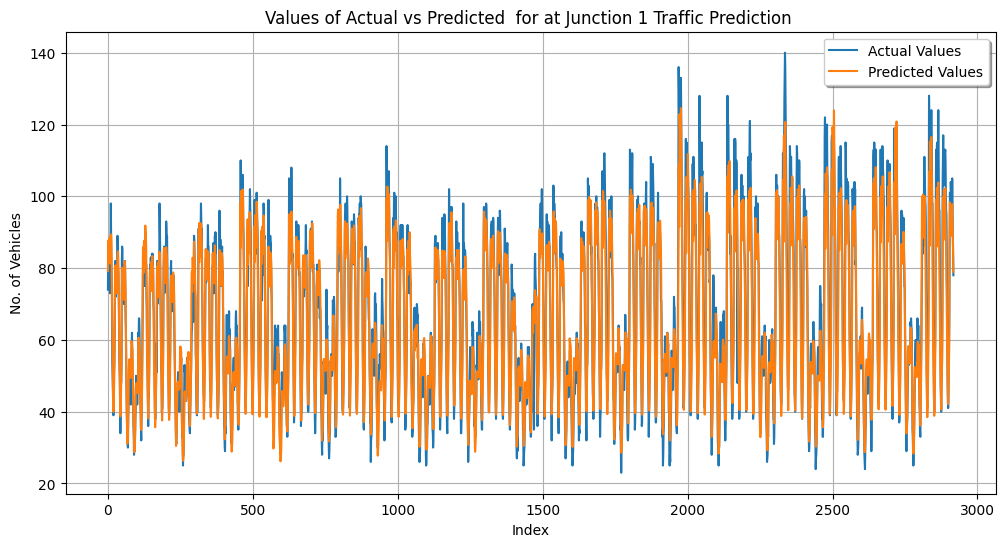

In [ ]:
import matplotlib.pyplot as plt

# Visualizing the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(range(len(validation_target_filtered)), validation_target_filtered, label="Actual Values")
plt.plot(range(len(validation_target_filtered)), filtered_predictions, label="Predicted Values")
plt.title("Values of Actual vs Predicted  for at Junction 1 Traffic Prediction ")
plt.xlabel('Index')
plt.ylabel('No. of Vehicles')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()


### Model tranining for Junction2

In [ ]:
# Prepare feature and target variables for Junction 2
features_junction2 = traffic_data_junction2.drop(['Vehicles', 'Seconds', 'ID', 'Junction'], axis=1)
target_junction2 = traffic_data_junction2['Vehicles']

# Determine the split index for training and validation sets (80% training, 20% validation)
split_index_junction2 = ceil(0.8 * len(traffic_data_junction2))

# Split the data into training and validation sets based on the calculated index
X_train_junction2 = features_junction2.iloc[:split_index_junction2]
y_train_junction2 = target_junction2.iloc[:split_index_junction2]
X_valid_junction2 = features_junction2.iloc[split_index_junction2:]
y_valid_junction2 = target_junction2.iloc[split_index_junction2:]


In [ ]:
# Define a list to store model names and their results
model_results = []

# Function to train and evaluate a model
def evaluate_model(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, predictions, squared=False)
    mape = mean_absolute_percentage_error(y_valid, predictions) * 100
    return rmse, mape

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "CatBoost": CatBoostRegressor(verbose=False, iterations=100),
    "LightGBM": LGBMRegressor(),
    "XGBoost": XGBRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "SVR": SVR(),
    "Linear SVR": LinearSVR()
}

# Evaluate each model and store the results
for model_name, model in models.items():
    rmse, mape = evaluate_model(model, X_train_junction2, y_train_junction2, X_valid_junction2, y_valid_junction2)
    model_results.append((model_name, rmse, mape))
    print(f"{model_name} RMSE: {rmse:.2f}")
    print(f"{model_name} MAPE: {mape:.2f}%")
    print('--------' * 20)

# Print all results
print("Model Performance Summary:")
for result in model_results:
    print(f"Model: {result[0]} - RMSE: {result[1]:.2f}, MAPE: {result[2]:.2f}%")

Linear Regression RMSE: 7.63
Linear Regression MAPE: 21.37%
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Lasso RMSE: 8.61
Lasso MAPE: 25.11%
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Ridge RMSE: 7.93
Ridge MAPE: 22.27%
----------------------------------------------------------------------------------------------------------------------------------------------------------------
CatBoost RMSE: 6.74
CatBoost MAPE: 18.65%
----------------------------------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

Chosing LGBMRegressor as best model and hypertuning it

In [ ]:
# Define and configure the LightGBM model
lightgbm_model_tuned = LGBMRegressor(num_iterations=170, learning_rate=0.08902)

# Train the model on the training data
lightgbm_model_tuned.fit(X_train_junction2, y_train_junction2)

# Generate predictions on the validation data
lightgbm_predictions_tuned = lightgbm_model_tuned.predict(X_valid_junction2)

# Calculate performance metrics
lightgbm_rmse_tuned = mean_squared_error(y_valid_junction2, lightgbm_predictions_tuned, squared=False)
lightgbm_mape_tuned = mean_absolute_percentage_error(y_valid_junction2, lightgbm_predictions_tuned) * 100
lightgbm_average_score_tuned = (lightgbm_rmse_tuned + lightgbm_mape_tuned) / 2

# Print the results
print(f"Average Score: {lightgbm_average_score_tuned:.2f}")
print(f"LightGBM RMSE on validation set: {lightgbm_rmse_tuned:.2f}")
print(f"LightGBM MAPE on validation set: {lightgbm_mape_tuned:.2f}%")
print('--------' * 20)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1783
[LightGBM] [Info] Number of data points in the train set: 11674, number of used features: 37
[LightGBM] [Info] Start training from score 11.893353
Average Score: 8.95
LightGBM RMSE on validation set: 4.38
LightGBM MAPE on validation set: 13.52%
----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
# Create a DataFrame to hold feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': features_junction2.columns,
    'Importance': lightgbm_model_tuned.feature_importances_
})

# Sort the DataFrame by importance scores in descending order
sorted_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame
sorted_feature_importance_df


,Feature,Importance
7,Time,715
0,DateTime,482
34,day_of_year_std_vehicles,364
29,Time_std_vehicles,361
5,day_of_week,349
37,day_of_year_mean_vehicles,321
6,day_of_year,280
35,day_of_year_max_vehicles,256
38,day_of_year_median_vehicles,234
4,day_of_month,206


In [ ]:
# Identify features with zero importance and remove them
zero_importance_features = list(sorted_feature_importance_df.loc[sorted_feature_importance_df['Importance'] == 0, 'Feature'])
filtered_features_junction2 = features_junction2.drop(zero_importance_features, axis=1).reset_index(drop=True)

# Split the data into training and validation sets based on the split index
X_train_filtered = filtered_features_junction2.iloc[:split_index_junction2]
y_train_filtered = target_junction2.iloc[:split_index_junction2]
X_valid_filtered = filtered_features_junction2.iloc[split_index_junction2:]
y_valid_filtered = target_junction2.iloc[split_index_junction2:]

# Define and configure the LightGBM model
lightgbm_model_filtered = LGBMRegressor(num_iterations=170, learning_rate=0.08902)

# Train the LightGBM model on the filtered training data
lightgbm_model_filtered.fit(X_train_filtered, y_train_filtered)

# Generate predictions on the filtered validation data
lightgbm_predictions_filtered = lightgbm_model_filtered.predict(X_valid_filtered)

# Calculate performance metrics
lightgbm_rmse_filtered = mean_squared_error(y_valid_filtered, lightgbm_predictions_filtered, squared=False)
lightgbm_mape_filtered = mean_absolute_percentage_error(y_valid_filtered, lightgbm_predictions_filtered) * 100
average_score_filtered = (lightgbm_rmse_filtered + lightgbm_mape_filtered) / 2

# Print the results
print(f"Average Score: {average_score_filtered:.2f}")
print(f"LightGBM RMSE error on validation data: {lightgbm_rmse_filtered:.2f}")
print(f"LightGBM MAPE error on validation data: {lightgbm_mape_filtered:.2f}%")
print('-------' * 20)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1764
[LightGBM] [Info] Number of data points in the train set: 11674, number of used features: 33
[LightGBM] [Info] Start training from score 11.893353
Average Score: 8.95
LightGBM RMSE error on validation data: 4.38
LightGBM MAPE error on validation data: 13.52%
--------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
# Perform cross-validation using the filtered features and target variables with LightGBM
lightgbm_cv_model = LGBMRegressor(num_iterations=170, learning_rate=0.08902)

# Execute the cross-validation process and obtain predictions
cv_predictions_filtered = time_series_cross_validation(filtered_features_junction2, target_junction2, regressor=lightgbm_cv_model)

# Display the cross-validation predictions
print("Cross-validation predictions:")
print(cv_predictions_filtered)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 826
[LightGBM] [Info] Number of data points in the train set: 1332, number of used features: 29
[LightGBM] [Info] Start training from score 8.403904
Trained Fold 0: RMSE: 3.7646489658402102, MAPE: 32.95000471138922, MAE: 2.958989452285667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1087
[LightGBM] [Info] Number of data points in the train set: 2658, number of used features: 32
[LightGBM] [Info] Start training from score 8.615500
Trained Fold 1: RMSE: 2.1154416307433364, MAPE: 17.92316092629691, MAE: 1.7118152819401256
[LightGBM]

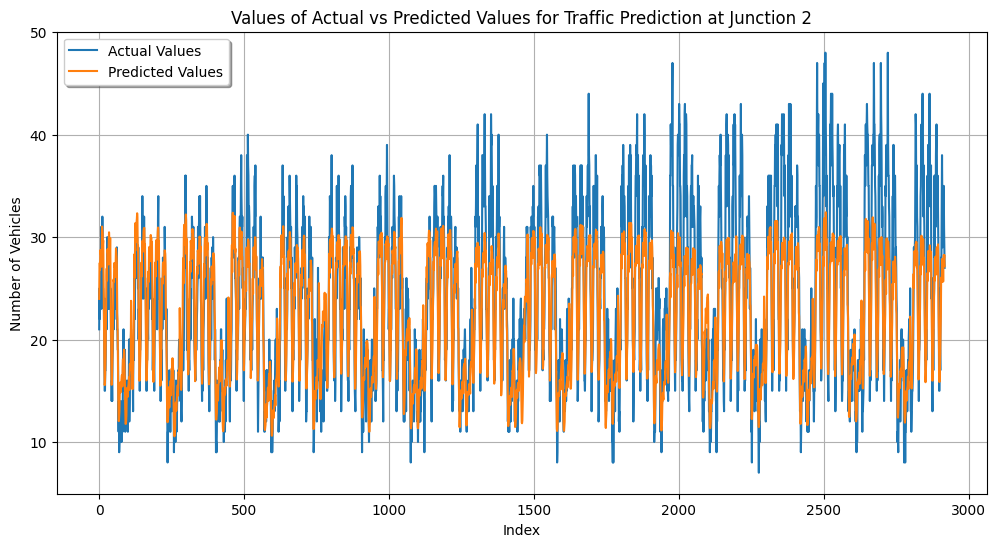

In [ ]:
import matplotlib.pyplot as plt

# Define the x-axis range based on the length of the validation set
x_axis = range(len(y_valid_filtered))

# Create a figure for the plot
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(x_axis, y_valid_filtered, label="Actual Values")

# Plot predicted values
plt.plot(x_axis, lightgbm_predictions_filtered, label="Predicted Values")

# Add title and labels
plt.title("Values of Actual vs Predicted Values for Traffic Prediction at Junction 2")
plt.xlabel('Index')
plt.ylabel('Number of Vehicles')

# Add legend and grid
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)

# Show the plot
plt.show()


### Saving Junction2 model

In [ ]:
import pickle

# Open a file to save the LightGBM model
with open("lightgbm_junction2_model.pkl", "wb") as model_file:
    # Save the trained LightGBM model to the file
    pickle.dump(lightgbm_model_filtered, model_file)

# Confirm that the model has been saved
print("LightGBM model for Junction 2 has been saved as 'lightgbm_junction2_model.pkl'")


LightGBM model for Junction 2 has been saved as 'lightgbm_junction2_model.pkl'


### Modelling for Junction3

In [ ]:
# Prepare feature and target variables for Junction 3
features_junction3 = traffic_data_junction3.drop(['Vehicles', 'Seconds', 'ID', 'Junction'], axis=1)
target_junction3 = traffic_data_junction3['Vehicles']

# Determine the split index for training and validation sets (80% training, 20% validation)
split_index_junction3 = ceil(0.8 * len(traffic_data_junction3))

# Split the data into training and validation sets based on the calculated index
X_train_junction3 = features_junction3.iloc[:split_index_junction3]
y_train_junction3 = target_junction3.iloc[:split_index_junction3]
X_valid_junction3 = features_junction3.iloc[split_index_junction3:]
y_valid_junction3 = target_junction3.iloc[split_index_junction3:]


In [ ]:
# Initialize and configure the LightGBM model for Junction 3
lightgbm_model_junction3 = LGBMRegressor(learning_rate=0.0099)

# Train the LightGBM model on the training data
lightgbm_model_junction3.fit(X_train_junction3, y_train_junction3)

# Generate predictions on the validation data
lightgbm_predictions_junction3 = lightgbm_model_junction3.predict(X_valid_junction3)

# Calculate performance metrics
lightgbm_rmse_junction3 = mean_squared_error(y_valid_junction3, lightgbm_predictions_junction3, squared=False)
lightgbm_mape_junction3 = mean_absolute_percentage_error(y_valid_junction3, lightgbm_predictions_junction3) * 100
average_score_junction3 = (lightgbm_rmse_junction3 + lightgbm_mape_junction3) / 2

# Print the results
print(f"Average Score: {average_score_junction3:.2f}")
print(f"LightGBM RMSE error on validation data: {lightgbm_rmse_junction3:.2f}")
print(f"LightGBM MAPE error on validation data: {lightgbm_mape_junction3:.2f}%")
print('--------' * 20)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1783
[LightGBM] [Info] Number of data points in the train set: 11674, number of used features: 37
[LightGBM] [Info] Start training from score 12.731112
Average Score: 21.29
LightGBM RMSE error on validation data: 9.21
LightGBM MAPE error on validation data: 33.38%
----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
# Create a DataFrame to hold feature names and their importance scores for Junction 3
feature_importance_junction3 = pd.DataFrame({
    'Feature': features_junction3.columns,
    'Importance': lightgbm_model_junction3.feature_importances_
})

# Sort the DataFrame by importance scores in descending order
sorted_feature_importance_junction3 = feature_importance_junction3.sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame
sorted_feature_importance_junction3


,Feature,Importance
0,DateTime,426
38,day_of_year_median_vehicles,419
35,day_of_year_max_vehicles,341
7,Time,306
5,day_of_week,260
29,Time_std_vehicles,191
37,day_of_year_mean_vehicles,179
8,Date,152
6,day_of_year,137
9,Month_std_vehicles,129


In [ ]:
# Identify and remove features with zero importance
zero_importance_features_junction3 = list(sorted_feature_importance_junction3.loc[sorted_feature_importance_junction3['Importance'] == 0, 'Feature'])
filtered_features_junction3 = features_junction3.drop(zero_importance_features_junction3, axis=1).reset_index(drop=True)

# Split the filtered data into training and validation sets
X_train_filtered_junction3 = filtered_features_junction3.iloc[:split_index_junction3]
y_train_filtered_junction3 = target_junction3.iloc[:split_index_junction3]
X_valid_filtered_junction3 = filtered_features_junction3.iloc[split_index_junction3:]
y_valid_filtered_junction3 = target_junction3.iloc[split_index_junction3:]

# Initialize and configure the LightGBM model for Junction 3
lightgbm_model_filtered_junction3 = LGBMRegressor(learning_rate=0.0099)

# Train the LightGBM model on the filtered training data
lightgbm_model_filtered_junction3.fit(X_train_filtered_junction3, y_train_filtered_junction3)

# Generate predictions on the filtered validation data
lightgbm_predictions_filtered_junction3 = lightgbm_model_filtered_junction3.predict(X_valid_filtered_junction3)

# Calculate performance metrics
lightgbm_rmse_filtered_junction3 = mean_squared_error(y_valid_filtered_junction3, lightgbm_predictions_filtered_junction3, squared=False)
lightgbm_mape_filtered_junction3 = mean_absolute_percentage_error(y_valid_filtered_junction3, lightgbm_predictions_filtered_junction3) * 100
average_score_filtered_junction3 = (lightgbm_rmse_filtered_junction3 + lightgbm_mape_filtered_junction3) / 2

# Print the results
print(f"Average Score: {average_score_filtered_junction3:.2f}")
print(f"LightGBM RMSE error on validation data: {lightgbm_rmse_filtered_junction3:.2f}")
print(f"LightGBM MAPE error on validation data: {lightgbm_mape_filtered_junction3:.2f}%")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1699
[LightGBM] [Info] Number of data points in the train set: 11674, number of used features: 23
[LightGBM] [Info] Start training from score 12.731112
Average Score: 21.29
LightGBM RMSE error on validation data: 9.21
LightGBM MAPE error on validation data: 33.38%


In [ ]:
# Define the LightGBM model with specified parameters for cross-validation
lightgbm_cv_model_junction3 = LGBMRegressor(learning_rate=0.0099)

# Perform cross-validation using the filtered features and target variables
cv_predictions_junction3 = time_series_cross_validation(filtered_features_junction3, target_junction3, regressor=lightgbm_cv_model_junction3)

# Display the cross-validation predictions
print("Cross-validation predictions for Junction 3:")
print(cv_predictions_junction3)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 1332, number of used features: 23
[LightGBM] [Info] Start training from score 5.632132
Trained Fold 0: RMSE: 8.04314553166192, MAPE: 48.26944661378329, MAE: 4.808570446616047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 2658, number of used features: 23
[LightGBM] [Info] Start training from score 7.513920
Trained Fold 1: RMSE: 9.49538132586139, MAPE: 43.44326838563969, MAE: 5.588388512540643
[LightGBM] [Inf

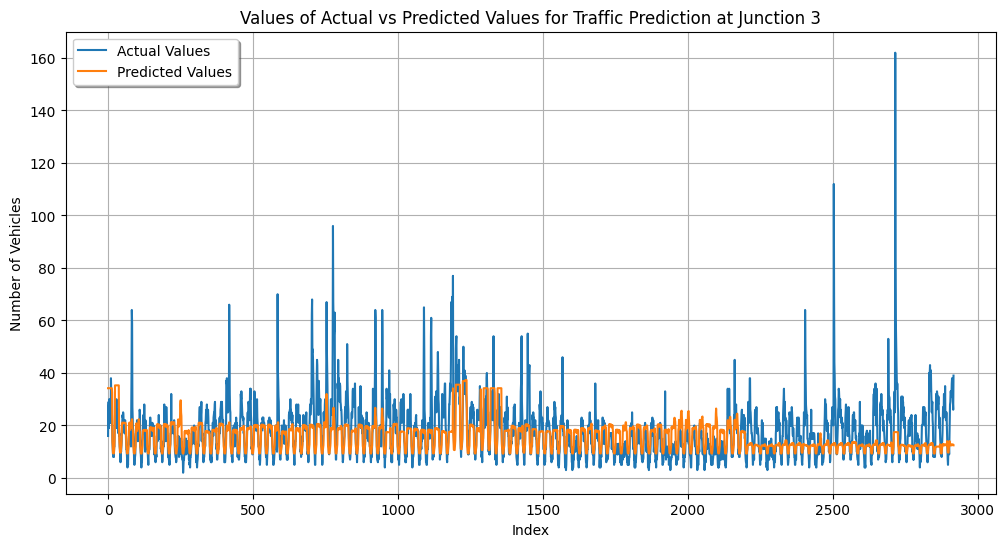

In [ ]:
import matplotlib.pyplot as plt

# Define the x-axis range based on the length of the validation set for Junction 3
x_axis_junction3 = range(len(y_valid_filtered_junction3))

# Create a figure for the plot
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(x_axis_junction3, y_valid_filtered_junction3, label="Actual Values")

# Plot predicted values
plt.plot(x_axis_junction3, lightgbm_predictions_filtered_junction3, label="Predicted Values")

# Add title and labels
plt.title("Values of Actual vs Predicted Values for Traffic Prediction at Junction 3")
plt.xlabel('Index')
plt.ylabel('Number of Vehicles')

# Add legend and grid
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
import pickle

# Open a file to save the LightGBM model for Junction 3
with open("lightgbm_junction3_model.pkl", "wb") as model_file_junction3:
    # Save the trained LightGBM model to the file
    pickle.dump(lightgbm_model_filtered_junction3, model_file_junction3)

# Confirm that the model has been saved
print("LightGBM model for Junction 3 has been saved as 'lightgbm_junction3_model.pkl'")


LightGBM model for Junction 3 has been saved as 'lightgbm_junction3_model.pkl'


### Modelling for Junction 4

In [ ]:
# Prepare feature and target variables for Junction 4
features_junction4 = traffic_data_junction4.drop(['Vehicles', 'Seconds', 'ID', 'Junction'], axis=1)
target_junction4 = traffic_data_junction4['Vehicles']

# Determine the split index for training and validation sets (80% training, 20% validation)
split_index_junction4 = ceil(0.8 * len(traffic_data_junction4))

# Split the data into training and validation sets based on the calculated index
X_train_junction4 = features_junction4.iloc[:split_index_junction4]
y_train_junction4 = target_junction4.iloc[:split_index_junction4]
X_valid_junction4 = features_junction4.iloc[split_index_junction4:]
y_valid_junction4 = target_junction4.iloc[split_index_junction4:]


In [ ]:
# Split the data into training and validation sets for Junction 4
X_train_junction4 = features_junction4.iloc[:split_index_junction4]
y_train_junction4 = target_junction4.iloc[:split_index_junction4]
X_valid_junction4 = features_junction4.iloc[split_index_junction4:]
y_valid_junction4 = target_junction4.iloc[split_index_junction4:]

# Initialize and configure the LightGBM model for Junction 4
lightgbm_model_junction4 = LGBMRegressor(num_iterations=69, learning_rate=0.099)

# Train the LightGBM model on the training data
lightgbm_model_junction4.fit(X_train_junction4, y_train_junction4)

# Generate predictions on the validation data
lightgbm_predictions_junction4 = lightgbm_model_junction4.predict(X_valid_junction4)

# Calculate performance metrics
lightgbm_rmse_junction4 = mean_squared_error(y_valid_junction4, lightgbm_predictions_junction4, squared=False)
lightgbm_mape_junction4 = mean_absolute_percentage_error(y_valid_junction4, lightgbm_predictions_junction4) * 100
average_score_junction4 = (lightgbm_rmse_junction4 + lightgbm_mape_junction4) / 2

# Print the results
print(f"Average Score: {average_score_junction4:.2f}")
print(f"LightGBM RMSE on validation set: {lightgbm_rmse_junction4:.2f}")
print(f"LightGBM MAPE on validation set: {lightgbm_mape_junction4:.2f}%")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1249
[LightGBM] [Info] Number of data points in the train set: 3476, number of used features: 35
[LightGBM] [Info] Start training from score 7.024453
Average Score: 15.97
LightGBM RMSE on validation set: 3.25
LightGBM MAPE on validation set: 28.68%


In [ ]:
# Create a DataFrame to hold feature names and their importance scores for Junction 4
feature_importance_junction4 = pd.DataFrame({
    'Feature': features_junction4.columns,
    'Importance': lightgbm_model_junction4.feature_importances_
})

# Sort the DataFrame by importance scores in descending order
sorted_feature_importance_junction4 = feature_importance_junction4.sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame
sorted_feature_importance_junction4


,Feature,Importance
0,DateTime,293
7,Time,267
29,Time_std_vehicles,170
34,day_of_year_std_vehicles,158
37,day_of_year_mean_vehicles,154
19,day_of_month_std_vehicles,105
35,day_of_year_max_vehicles,103
30,Time_max_vehicles,98
4,day_of_month,92
38,day_of_year_median_vehicles,84


In [ ]:
# Identify and remove features with zero importance
zero_importance_features_junction4 = list(sorted_feature_importance_junction4.loc[sorted_feature_importance_junction4['Importance'] == 0, 'Feature'])
filtered_features_junction4 = features_junction4.drop(zero_importance_features_junction4, axis=1).reset_index(drop=True)

# Split the filtered data into training and validation sets
X_train_filtered_junction4 = filtered_features_junction4.iloc[:split_index_junction4]
y_train_filtered_junction4 = target_junction4.iloc[:split_index_junction4]
X_valid_filtered_junction4 = filtered_features_junction4.iloc[split_index_junction4:]
y_valid_filtered_junction4 = target_junction4.iloc[split_index_junction4:]

# Initialize and configure the LightGBM model for Junction 4
lightgbm_model_filtered_junction4 = LGBMRegressor(num_iterations=69, learning_rate=0.099)

# Train the LightGBM model on the filtered training data
lightgbm_model_filtered_junction4.fit(X_train_filtered_junction4, y_train_filtered_junction4)

# Generate predictions on the filtered validation data
lightgbm_predictions_filtered_junction4 = lightgbm_model_filtered_junction4.predict(X_valid_filtered_junction4)

# Calculate performance metrics
lightgbm_rmse_filtered_junction4 = mean_squared_error(y_valid_filtered_junction4, lightgbm_predictions_filtered_junction4, squared=False)
lightgbm_mape_filtered_junction4 = mean_absolute_percentage_error(y_valid_filtered_junction4, lightgbm_predictions_filtered_junction4) * 100
lightgbm_mae_filtered_junction4 = mean_absolute_error(y_valid_filtered_junction4, lightgbm_predictions_filtered_junction4)
average_score_filtered_junction4 = (lightgbm_rmse_filtered_junction4 + lightgbm_mape_filtered_junction4) / 2

# Print the results
print(f"Average Score: {average_score_filtered_junction4:.2f}")
print(f"LightGBM RMSE on validation set: {lightgbm_rmse_filtered_junction4:.2f}")
print(f"LightGBM MAPE on validation set: {lightgbm_mape_filtered_junction4:.2f}%")
print(f"LightGBM MAE on validation set: {lightgbm_mae_filtered_junction4:.2f}")
print('--------' * 20)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1071
[LightGBM] [Info] Number of data points in the train set: 3476, number of used features: 26
[LightGBM] [Info] Start training from score 7.024453
Average Score: 15.97
LightGBM RMSE on validation set: 3.25
LightGBM MAPE on validation set: 28.68%
LightGBM MAE on validation set: 2.20
----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
# Define the LightGBM model with specified parameters for cross-validation
lightgbm_cv_model_junction4 = LGBMRegressor(num_iterations=69, learning_rate=0.099)

# Perform cross-validation using the filtered features and target variables
cv_predictions_junction4 = time_series_cross_validation(filtered_features_junction4, target_junction4, regressor=lightgbm_cv_model_junction4)

# Display the cross-validation predictions
print("Cross-validation predictions for Junction 4:")
print(cv_predictions_junction4)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 438
[LightGBM] [Info] Number of data points in the train set: 404, number of used features: 22
[LightGBM] [Info] Start training from score 7.586634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

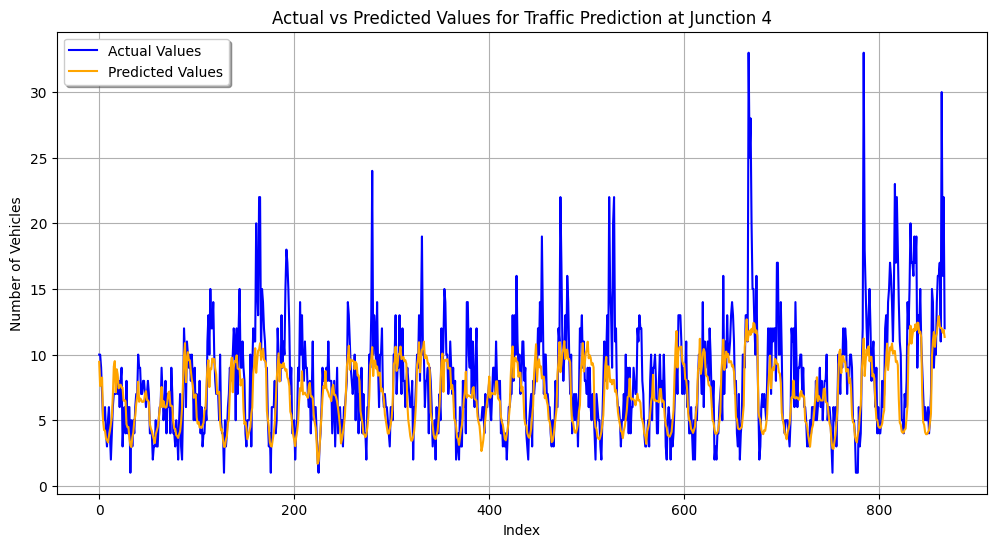

In [ ]:
import matplotlib.pyplot as plt

# Define the x-axis range based on the length of the validation set for Junction 4
x_axis_junction4 = range(len(y_valid_filtered_junction4))

# Create a figure for the plot
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(x_axis_junction4, y_valid_filtered_junction4, label="Actual Values", color='blue')

# Plot predicted values
plt.plot(x_axis_junction4, lightgbm_predictions_filtered_junction4, label="Predicted Values", color='orange')

# Add title and labels
plt.title("Actual vs Predicted Values for Traffic Prediction at Junction 4")
plt.xlabel('Index')
plt.ylabel('Number of Vehicles')

# Add legend and grid
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
import pickle

# Open a file to save the LightGBM model for Junction 4
with open("lightgbm_junction4_model.pkl", "wb") as model_file_junction4:
    # Save the trained LightGBM model to the file
    pickle.dump(lightgbm_model_filtered_junction4, model_file_junction4)

# Confirm that the model has been saved
print("LightGBM model for Junction 4 has been saved as 'lightgbm_junction4_model.pkl'")


LightGBM model for Junction 4 has been saved as 'lightgbm_junction4_model.pkl'


## References

https://ridwan-space.medium.com/forecast-temperature-%EF%B8%8F-f9b716f7a46e